This is the third part of the first lab.

The setup remains the same as in the previous parts, and the following is included only in case this part is not conducted immendately after the second part.  


###### Setup:  
-- `ssh-add` (Machine A) #if it fails, run first: eval `ssh-agent -s`  
-- `mkdir /home/l51/<crsid>` (Machine A, replace <crsid> with your crsid) 
  
-- `cd /home/l51/<crsid>` Machine A)  
-- `git clone http://github.com/cucl-srg/P51a` (Machine A)  
-- `/home/l51/P51a/setup/mkdir1.sh <crsid>`. (Machine A)   


In [2]:
crsid='sl955' #your crsid
%run /home/l51/$crsid/P51a/Jupyter/useful/useful.py
%run /home/l51/$crsid/P51a/Jupyter/useful/useful1.py
%matplotlib inline
machA_ip = '128.232.82.184'
machB_ip = '128.232.82.185'  #  XXX REPLACE THIS WITH THE IP of the host 128.232.XXX.YYY

# 3. iperf

iperf is used to test the maximum network throughput that a computer can handle. The DuT acts as an iperf server and listens for connections. A second computer connects to the server and sends datagrams.  
  
In bidirectional testing, both computers act as both servers (receiving) and clients (sending).  
  
###### Usage of iperf: 
    
Server:  
* TCP       
`iperf -s -B <server address>`  
* UDP      
`iperf -s -B <server address>` -u   
   
Client:  
* TCP     
`iperf -c <server address> [Opt: -i <interval>] [Opt: -t <time>] [Opt: -f <format>] [Opt: -d] [Opt: -w <TCP window size>]`  
interval = how often to report bandwidth in seconds. Default is no periodic reports.  
time = length of test in seconds. Default value is 10.    
format = 'k' for Kbits/sec, 'm' for Mbits/sec, 'g' for Gbits/sec. Default is adaptive.    
-d = bidirectional  
TCP window size -> eg. `-w 20KB`
    
      
* UDP    
`iperf -c <server address> -u [Opt: -i <interval>] [Opt: -t <time>] [Opt: -f <format>] [Opt: -d] [Opt: -b <bandwidth>]`   
bandwidth -> eg. `-b 20m` (Mbits/sec).  

NB. By default, iperf restricts bandwidth for UDP clients to a maximum of 1 Mbit/sec. There is no restriction for TCP clients.   

### Experiment 9

Run one way iperf, from A to B, 10 sec long. Plot the bandwidth for each time interval (1 sec).

<font color='red'>TODO:</font> Fill in `server_cmd`, the command to start the server. Fill in `client_cmd`, the command to connect to the server, 10 seconds long, interval 1 second, format Gbits/sec.

In [9]:
server_cmd = f'sudo iperf -s -B {machB_ip}'
ssh = ssh_connect(machB_ip)
start_new_thread(ssh_cmd,(server_cmd,ssh))

for i in range(5):
    sleep(1)
    client_cmd = f'sudo iperf -c {machB_ip} -i 1 -t 10 -f g'
    local_cmd(client_cmd+'| grep -e "bits/sec" -m 10 > /home/l51/'+crsid+'/P51aLab1/9/exp9_' + str(i))

ssh_cmd('sudo pkill iperf', ssh)
ssh.close()

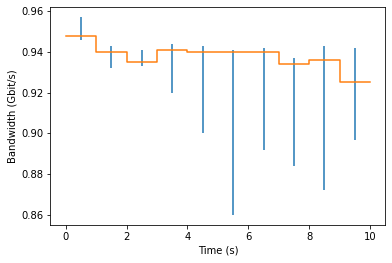

In [10]:
bws = data_iperf('9/exp9',crsid)
ys, yerr = graph_error(bws)
plt.errorbar(np.arange(0.5,10.0,1.0),ys,yerr=yerr,linestyle="none")
ys.append(ys[-1])
plt.step(np.arange(0,11,1), ys ,where="post")

plt.xlabel("Time (s)")
plt.ylabel("Bandwidth (Gbit/s)")
plt.show()

### Experiment 10

Run 2 way iperf, 10 sec long. Plot the bandwidth for each time interval (1 sec).

<font color='red'>TODO:</font> Fill in `server_cmd`, the command to start the server. Fill in `client_cmd`, the command to connect to the server, bidirectional, 10 seconds long, interval 1 second, format Gbits/sec.

In [8]:
server_cmd = f'iperf -s -B {machB_ip}'
ssh = ssh_connect(machB_ip)
start_new_thread(ssh_cmd,(server_cmd,ssh))

for i in range(5):
    sleep(1)
    client_cmd = f'iperf -c {machB_ip} -i 1 -t 10 -f g -d'
    local_cmd(client_cmd+' | grep -e "bits/sec" -e "with" -m 22 > /home/l51/'+crsid+'/P51aLab1/10/exp10_' + str(i))

ssh_cmd('sudo pkill iperf3', ssh)
ssh.close()

In [ ]:
def data10(crsid):
    sbw = [[] for i in range(10)]
    cbw = [[] for i in range(10)]
    for j in range(5):
        with open('/home/l51/'+crsid+'/P51aLab1/10/exp10_' + str(j)) as f:
            next(f)
            next(f)
            for i in range(10):
                sb = next(f)
                sbww = findall(r'GBytes(.*?)Gbits/sec', sb)[0]
                sbw[i].append(float(sbww))
                cb = next(f)
                cbww = findall(r'GBytes(.*?)Gbits/sec', cb)[0]
                cbw[i].append(float(cbww))
    return sbw, cbw

In [42]:
sbw,cbw = data10(crsid)
ys,yerr = graph_error(sbw)
plt.errorbar(np.arange(0.4,10.0,1.0),ys,yerr=yerr,linestyle="none",color="red")
ys.append(ys[-1])
plt.step(np.arange(0,11,1), ys ,where="post",color="red",label="server")

ys2,yerr2 = graph_error(cbw)
plt.errorbar(np.arange(0.6,10.0,1.0),ys2,yerr=yerr2,linestyle="none",color="blue")
ys2.append(ys2[-1])
plt.step(np.arange(0,11,1), ys2 ,where="post",color="blue",label="client")
    
plt.xlabel("Time (s)")
plt.ylabel("Bandwidth (Mbit/s)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

[  7][RX-C]   0.00-1.00   sec  89.1 MBytes  0.75 Gbits/sec                  

0 [  5][TX-C]   1.00-2.00   sec   104 MBytes  0.87 Gbits/sec    0   1.69 MBytes       

1 [  5][TX-C]   2.00-3.00   sec   104 MBytes  0.87 Gbits/sec    0   1.88 MBytes       

2 [  5][TX-C]   3.00-4.00   sec  87.5 MBytes  0.73 Gbits/sec    0   2.01 MBytes       

3 [  5][TX-C]   4.00-5.00   sec  88.8 MBytes  0.74 Gbits/sec    0   2.17 MBytes       

4 [  5][TX-C]   5.00-6.00   sec  97.5 MBytes  0.82 Gbits/sec    0   2.34 MBytes       

5 [  5][TX-C]   6.00-7.00   sec   104 MBytes  0.87 Gbits/sec    0   2.34 MBytes       

6 [  5][TX-C]   7.00-8.00   sec  97.5 MBytes  0.82 Gbits/sec    0   2.34 MBytes       

7 [  5][TX-C]   8.00-9.00   sec   102 MBytes  0.86 Gbits/sec    0   2.46 MBytes       

8 [  5][TX-C]   9.00-10.00  sec   104 MBytes  0.87 Gbits/sec    0   2.46 MBytes       

9 [  5][TX-C]   0.00-10.00  sec   988 MBytes  0.83 Gbits/sec    0             sender

[  7][RX-C]   0.00-1.00   sec   100 MBytes  

IndexError: list index out of range

### Experiment 11

Run one way iperf, from A to B, 3 sec long, with varying window size. Plot the bandwidth for each window size.

<font color='red'>TODO:</font> Fill in `server_cmd`, the command to start the server. Fill in `client_cmd`, the command to connect to the server, 3 seconds long, format Kbits/sec, for each window size in KB.

In [4]:
server_cmd = f'iperf -s -B {machB_ip}'
ssh = ssh_connect(machB_ip)
start_new_thread(ssh_cmd,(server_cmd,ssh))

windows = [1,50,100,150,200,250]
for w in windows:
    for i in range(5):
        sleep(1)
        client_cmd = f'iperf -c {machB_ip} -i 1 -t 3 -f k -w {w}KB'
        local_cmd(client_cmd+' | grep -e "window" -e "bits/sec" > /home/l51/'+crsid+'/P51aLab1/11/exp11_'+str(w)+'_'+str(i))
    
ssh_cmd('sudo pkill iperf', ssh)
ssh.close()

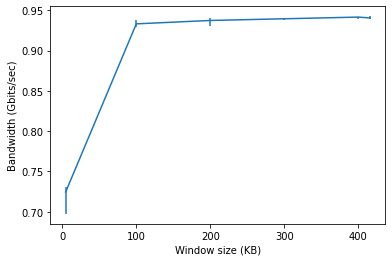

In [5]:
winds, bws = data11(windows,crsid)
ys,yerr =graph_error(bws)
plt.errorbar(winds,ys,yerr=yerr)
plt.ylabel("Bandwidth (Gbits/sec)")
plt.xlabel("Window size (KB)")
plt.show()

### Experiment 12

Run one way iperf using UDP, from A to B, 3 sec long, with varying bandwidth. Plot the percentage of packets dropped for each bandwidth.

<font color='red'>TODO:</font> Fill in `server_cmd`, the command to start the UDP server. Fill in `client_cmd`, the command to connect to the UDP server, 3 seconds long, format Mbits/sec, for each bandwidth in Mbits/sec.

In [3]:
server_cmd = f'iperf -s -B {machB_ip} -u'
ssh = ssh_connect(machB_ip)
start_new_thread(ssh_cmd,(server_cmd,ssh))

bands = [10,100,1000,5000,9000]
for b in bands:
    for i in range(5):
        sleep(1)
        client_cmd = f'iperf -c {machB_ip} -i 1 -t 3 -f m -b {b}m -u'
        local_cmd(client_cmd+' | grep -e "%"> /home/l51/'+crsid+'/P51aLab1/12/exp12_'+str(b)+ '_'+ str(i))
    
ssh_cmd('sudo pkill iperf', ssh)
ssh.close()

<font color='red'>TODO:</font> Plot a graph of percentage of packets dropped against bandwidth, with error bars.

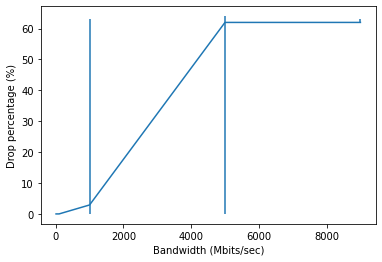

In [4]:
bans,pcs = data_band('12/exp12',crsid,bands)
ys, yerr = graph_error(pcs)
plt.errorbar(bands,ys,yerr=yerr)
plt.ylabel("Drop percentage (%)")
plt.xlabel("Bandwidth (Mbits/sec)")
plt.show()

### Experiment 13

###### Usage of iperf3 :   
  
Server:  
* TCP/UDP      
`iperf3 -s -B <server address>`     
     
Client:  
* TCP     
`iperf3 -c <server address> [Opt: -i <interval>] [Opt: -t <time>] [Opt: -f <format>] [Opt: -w <window size>]`     
* UDP     
`iperf3 -c <server address> [Opt: -i <interval>] [Opt: -t <time>] [Opt: -f <format>] [Opt: -b <bandwidth>]`

### 13a

Run one way iperf, from A to B, 10 sec long. Plot the bandwidth for each time interval (1 sec).

<font color='red'>TODO:</font> Fill in `server_cmd`, the command to start the server. Fill in `client_cmd`, the command to connect to the server, 10 seconds long, format Gbits/sec, interval 1 second.

In [2]:
server_cmd = f'iperf3 -s -B {machB_ip}'
ssh = ssh_connect(machB_ip)
start_new_thread(ssh_cmd,(server_cmd,ssh))

for i in range(5):
    sleep(1)
    client_cmd = f'iperf3 -c {machB_ip} -i 1 -t 10 -f g'
    local_cmd(client_cmd+' | grep -e "bits/sec" -m 10 > /home/l51/'+crsid+'/P51aLab1/13/exp13a_' + str(i))

ssh_cmd('sudo pkill iperf3', ssh)
ssh.close()

KeyboardInterrupt: 

<font color='red'>TODO:</font> Plot a step graph of bandwidth against time, with error bars.

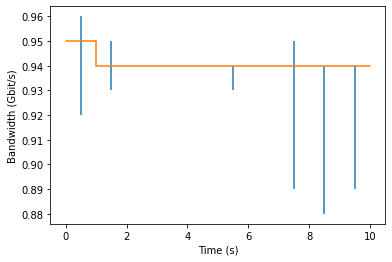

In [20]:
bws = data_iperf('13/exp13a',crsid)
ys, yerr = graph_error(bws)

plt.errorbar(np.arange(0.5,10.0,1.0),ys,yerr=yerr,linestyle="none")
ys.append(ys[-1])
plt.step(np.arange(0,11,1), ys ,where="post")

plt.xlabel("Time (s)")
plt.ylabel("Bandwidth (Gbit/s)")
plt.show()

### 13b

Run one way iperf, from A to B, 3 sec long, with varying window size. Plot the bandwidth for each window size.

<font color='red'>TODO:</font> Fill in `server_cmd`, the command to start the server. Fill in `client_cmd`, the command to connect to the server, 3 seconds long, format Mbits/sec, for every window size in KB.

In [3]:
server_cmd = f'iperf3 -s -B {machB_ip}'
ssh = ssh_connect(machB_ip)
start_new_thread(ssh_cmd,(server_cmd,ssh))

windows = [1,50,100,150,200,250]
for w in windows:
    for i in range(5):
        sleep(1)
        client_cmd = f'iperf3 -c {machB_ip} -i 1 -t 3 -f m -w {w}KB'
        local_cmd(client_cmd +' | grep -e "bits/sec" > /home/l51/'+crsid+'/P51aLab1/13/exp13b_'+str(w)+'_'+str(i))
    
ssh_cmd('sudo pkill iperf3', ssh)
ssh.close()

<font color='red'>TODO:</font> Plot a graph of bandwidth against window size, with error bars.

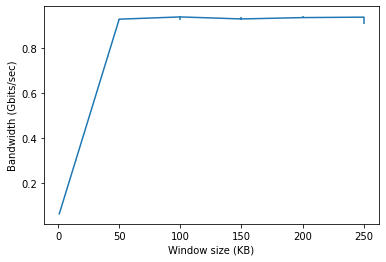

In [4]:
bws = data13b(windows,crsid)
ys,yerr = graph_error(bws)


plt.errorbar(windows,ys,yerr=yerr)
plt.ylabel("Bandwidth (Gbits/sec)")
plt.xlabel("Window size (KB)")
plt.show()

### 13c

Run one way iperf using UDP, from A to B, 3 sec long, with varying bandwidth. Plot the percentage of packets dropped for each bandwidth.

<font color='red'>TODO:</font> Fill in `server_cmd`, the command to start the UDP server. Fill in `client_cmd`, the command to connect to the UDP server, 3 seconds long, format Mbits/sec, for every bandwidth in Mbits/sec.

In [5]:
server_cmd = f'iperf3 -s -B {machB_ip}'
ssh = ssh_connect(machB_ip)
start_new_thread(ssh_cmd,(server_cmd,ssh))

bands = [10,100,1000,5000,9000]
for b in bands:
    for i in range(5):
        sleep(1)
        client_cmd = f'iperf3 -c {machB_ip} -i 1 -t 3 -f m -b {b}M -u'
        local_cmd(client_cmd+' | grep -e "%.*receiver" > /home/l51/'+crsid+'/P51aLab1/13/exp13c_'+str(b)+'_'+str(i))
    
ssh_cmd('sudo pkill iperf3', ssh)
ssh.close()

<font color='red'>TODO:</font> Plot a graph of percentage of packets dropped against bandwidth, with error bars.

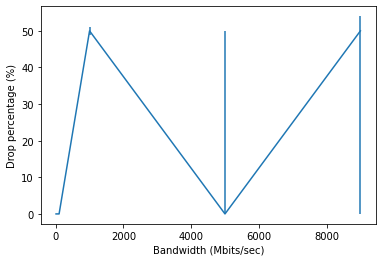

In [6]:
bans,pcs = data_band('13/exp13c',crsid,bands)
ys, yerr = graph_error(pcs)

plt.errorbar(bands,ys,yerr=yerr)
plt.ylabel("Drop percentage (%)")
plt.xlabel("Bandwidth (Mbits/sec)")
plt.show()